<a href="https://colab.research.google.com/github/AnnaGavri1ova/Python2030_part1/blob/main/Gavrilova_Anna_%22HW_1_GraphSage_Guide_with_FRANKENSTEIN_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GraphSAGE

Inspired by [@maximelabonne](https://twitter.com/maximelabonne).


In [ ]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 52.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Dataset

In [ ]:
!wget https://nrvis.com/download/data/labeled/FRANKENSTEIN.zip

--2023-12-08 11:45:59--  https://nrvis.com/download/data/labeled/FRANKENSTEIN.zip
Resolving nrvis.com (nrvis.com)... 173.236.176.48
Connecting to nrvis.com (nrvis.com)|173.236.176.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14030729 (13M) [application/zip]
Saving to: ‘FRANKENSTEIN.zip.1’

FRANKENSTEIN.zip.1    0%[                    ]       0  --.-KB/s               ^C


In [ ]:
!unzip /content/FRANKENSTEIN.zip

Archive:  /content/FRANKENSTEIN.zip
replace FRANKENSTEIN.edges? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import torch
import os
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data, download_url, extract_zip, DataLoader
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

To create the dataset we need to convert the raw information into a Data object (a graph) in PyG.

The first step is to load the csv files, this can be done manually or using some data library as Pandas:
нужно преобразовать необработанную информацию в объект данных (график) в PyG.

Первым шагом является загрузка csv-файлов, это можно сделать вручную или с помощью какой-либо библиотеки данных, такой как Pandas:



нужно преобразовать необработанную информацию в объект данных (график) в PyG.

Первым шагом является загрузка csv-файлов, это можно сделать вручную или с помощью какой-либо библиотеки данных, такой как Pandas:

In [ ]:
raw_dir = "/content/"


path = os.path.join(raw_dir, 'FRANKENSTEIN.node_attrs')
node_attrs = pd.read_csv(path, sep=',', header=None)
node_attrs.index += 1

path = os.path.join(raw_dir, 'FRANKENSTEIN.edges')
edge_index = pd.read_csv(path, sep=',', names=['source', 'target'])
edge_index.index += 1

path = os.path.join(raw_dir, 'FRANKENSTEIN.graph_idx')
graph_idx = pd.read_csv(path, sep=',', names=['idx'])
graph_idx.index += 1

path = os.path.join(raw_dir, 'FRANKENSTEIN.graph_labels')
graph_labels = pd.read_csv(path, sep=',', names=['label'])
graph_labels.index += 1

In [ ]:
node_attrs

,0,1,2,3,4,5,6,7,8,9,...,770,771,772,773,774,775,776,777,778,779
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73279,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
73280,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
73281,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
73282,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
node_attrs.head()

,0,1,2,3,4,5,6,7,8,9,...,770,771,772,773,774,775,776,777,778,779
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
edge_index.head()

,source,target
1,1,2
2,2,1
3,1,3
4,3,1
5,1,4


In [ ]:
graph_idx['idx'].nunique()

4337

In [ ]:
graph_labels['label'].unique()

array([ 1, -1])

Graph ids go from 1 to 4337, let's extract the information for a single graph (id: 2345)


Идентификаторы графиков варьируются от 1 до 4337, давайте извлекем информацию для одного графика (id: 2345)

In [ ]:
g_idx=2345

node_ids = graph_idx.loc[graph_idx['idx']==g_idx].index

# Node features
attributes = node_attrs.loc[node_ids, :]

# Edges info
edges = edge_index.loc[edge_index['source'].isin(node_ids)]
edges_ids = edges.index

# Graph label
label = graph_labels.loc[g_idx]

In [ ]:
node_ids, attributes

(Int64Index([38571, 38572, 38573, 38574, 38575, 38576, 38577, 38578, 38579,
             38580, 38581, 38582, 38583, 38584, 38585, 38586, 38587, 38588],
            dtype='int64'),
        0    1    2    3    4    5    6    7    8    9    ...  770  771  772  \
 38571    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
 38572    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
 38573    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
 38574    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
 38575    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
 38576    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
 38577    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
 38578    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
 38579    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
 38580    0    0   

In [ ]:
attributes


,0,1,2,3,4,5,6,7,8,9,...,770,771,772,773,774,775,776,777,778,779
38571,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
38572,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
38573,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
38574,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
38575,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
38576,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
38577,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
38578,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
38579,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
38580,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
print("Nodes:", node_ids.shape)
print("Attributes:", attributes.shape)
print("Edges:", edges.shape)
print("Label:", label.shape)

Nodes: (18,)
Attributes: (18, 780)
Edges: (38, 2)
Label: (1,)


In [ ]:
print("Nodes:", node_ids)
print("Attributes:", attributes)
print("Edges:", edges)
print("Label:", label)

Nodes: Int64Index([38571, 38572, 38573, 38574, 38575, 38576, 38577, 38578, 38579,
            38580, 38581, 38582, 38583, 38584, 38585, 38586, 38587, 38588],
           dtype='int64')
Attributes:        0    1    2    3    4    5    6    7    8    9    ...  770  771  772  \
38571    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
38572    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
38573    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
38574    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
38575    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
38576    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
38577    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
38578    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
38579    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
38580    0    

At this stage the indices in the edges variable are not normalized for the single graph, e.g. they do not start from 0

На этом этапе индексы в переменной edges не нормализуются для отдельного графика, например, они не начинаются с 0


In [ ]:
edge_idx = torch.tensor(edges.to_numpy().transpose(), dtype=torch.long)
map_dict = {v.item():i for i,v in enumerate(torch.unique(edge_idx))}
map_edge = torch.zeros_like(edge_idx)
for k,v in map_dict.items():
    map_edge[edge_idx==k] = v

In [ ]:
map_dict, map_edge, map_edge.shape

({38571: 0,
  38572: 1,
  38573: 2,
  38574: 3,
  38575: 4,
  38576: 5,
  38577: 6,
  38578: 7,
  38579: 8,
  38580: 9,
  38581: 10,
  38582: 11,
  38583: 12,
  38584: 13,
  38585: 14,
  38586: 15,
  38587: 16,
  38588: 17},
 tensor([[ 0,  1,  0,  2,  0,  3,  1,  4,  1,  5,  2,  6,  3,  7,  4,  8,  4,  9,
           6, 10,  7, 10, 10, 11, 11, 12, 12, 13, 12, 14, 13, 15, 14, 16, 15, 17,
          16, 17],
         [ 1,  0,  2,  0,  3,  0,  4,  1,  5,  1,  6,  2,  7,  3,  8,  4,  9,  4,
          10,  6, 10,  7, 11, 10, 12, 11, 13, 12, 14, 12, 15, 13, 16, 14, 17, 15,
          17, 16]]),
 torch.Size([2, 38]))

As final step we convert the DataFrames to torch tensors. The node features are basically MNIST images, therefore their size should be 784 (28x28), but for some reason the files provide vectors of length 780. To adjust this, we simply add a padding of 4 zeros at the end of the vector (it will not affect the digits representation, as we'll see later).

В качестве заключительного шага мы преобразуем фреймы данных в тензоры torch. Объекты узла в основном представляют собой изображения MNIST, поэтому их размер должен быть 784 (28x28), но по какой-то причине файлы предоставляют векторы длиной 780. Чтобы настроить это, мы просто добавим дополнение из 4 нулей в конце вектора (это не повлияет на представление цифр, как мы увидим позже).

In [ ]:
attrs = torch.tensor(attributes.to_numpy(), dtype=torch.float)
pad = torch.zeros((attrs.shape[0], 4), dtype=torch.float)
x = torch.cat((attrs, pad), dim=-1)

edge_idx = map_edge.long()

np_lab = label.to_numpy()
y = torch.tensor(np_lab if np_lab[0] == 1 else [0], dtype=torch.long)

In [ ]:
x.shape

torch.Size([18, 784])

Then we create the Data object representing the graph



In [ ]:
graph = Data(x=x, edge_index=edge_idx,  y=y)


Let's visualize the graph!

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


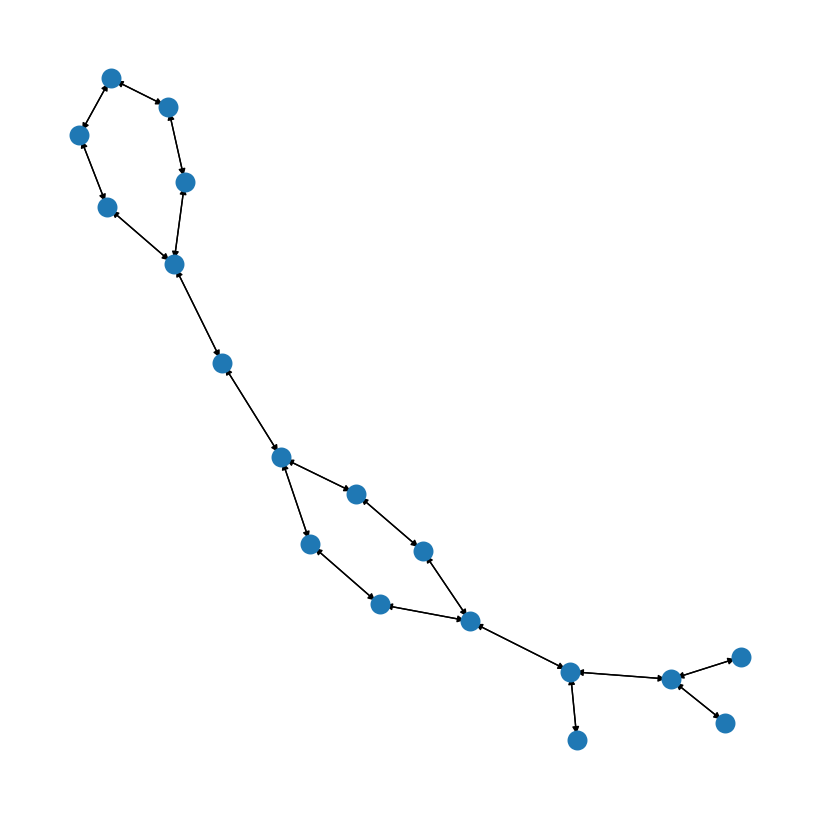

In [ ]:
vis = to_networkx(graph)
plt.figure(1,figsize=(8,8))
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_size=70,linewidths=6)
plt.show()

We can also plot the vertices attributes (a.k.a. the digits):


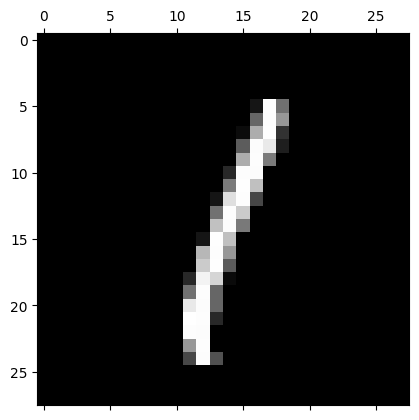

In [ ]:
digit = x[6].reshape(28,28)
plt.matshow(digit, cmap='gray')

Save all graphs

In [ ]:
data_list =[]

for g_idx in tqdm(graph_idx['idx'][:]):
    node_ids = graph_idx.loc[graph_idx['idx']==g_idx].index

    # Node features
    attributes = node_attrs.loc[node_ids, :]

    # Edges info
    edges = edge_index.loc[edge_index['source'].isin(node_ids)]
    edges_ids = edges.index

    # Graph label
    label = graph_labels.loc[g_idx]

    edge_idx = torch.tensor(edges.to_numpy().transpose(), dtype=torch.long)
    map_dict = {v.item():i for i,v in enumerate(torch.unique(edge_idx))}
    map_edge = torch.zeros_like(edge_idx)
    for k,v in map_dict.items():
        map_edge[edge_idx==k] = v

    attrs = torch.tensor(attributes.to_numpy(), dtype=torch.float)
    pad = torch.zeros((attrs.shape[0], 4), dtype=torch.float)
    x = torch.cat((attrs, pad), dim=-1)

    edge_idx = map_edge.long()

    np_lab = label.to_numpy()
    y = torch.tensor(np_lab if np_lab[0] == 1 else [0], dtype=torch.long)


    # Create data object
    data = Data(x=x, edge_index=edge_idx,  y=y)

    data_list.append(data)

100%|██████████| 73283/73283 [06:13<00:00, 196.31it/s]


##TASK 1

Load FRANKENSTEIN dataset. (SEE THE SEMINAR 4)

Split it to train, validation and test parts.

Get some statistics.
Загрузите набор данных FRANKENSTEIN. (СМОТРИТЕ СЕМИНАР 4)

Разделите его на части обучения, проверки и тестирования.

Получите некоторую статистику.

**5 points**

In [ ]:
import torch
import os
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data, download_url, extract_zip
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from tqdm import tqdm


class Frankenstein(InMemoryDataset):

    # Base url to download the files
    url = 'http://nrvis.com/download/data/labeled/FRANKENSTEIN.zip'

    def __init__(self, root, transform=None, pre_transform=None):
        super(Frankenstein, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        # List of the raw files
        return ['FRANKENSTEIN.edges', 'FRANKENSTEIN.graph_idx',
                'FRANKENSTEIN.graph_labels', 'FRANKENSTEIN.node_attrs']

    @property
    def processed_file_names(self):
        return 'data.pt'

    def download(self):
        # Download the file specified in self.url and store
        # it in self.raw_dir
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        # The zip file is removed
        os.unlink(path)


    def process(self):
        # Read the files' content as Pandas DataFrame. Nodes and graphs ids
        # are based on the file row-index, we adjust the DataFrames indices
        # by starting from 1 instead of 0.

        path = os.path.join(self.raw_dir, 'FRANKENSTEIN.node_attrs')
        node_attrs = pd.read_csv(path, sep=',', header=None)
        node_attrs.index += 1

        path = os.path.join(self.raw_dir, 'FRANKENSTEIN.edges')
        edge_index = pd.read_csv(path, sep=',', names=['source', 'target'])
        edge_index.index += 1

        path = os.path.join(self.raw_dir, 'FRANKENSTEIN.graph_idx')
        graph_idx = pd.read_csv(path, sep=',', names=['idx'])
        graph_idx.index += 1

        path = os.path.join(self.raw_dir, 'FRANKENSTEIN.graph_labels')
        graph_labels = pd.read_csv(path, sep=',', names=['label'])
        graph_labels.index += 1


        # In the loop we extract the nodes' embeddings, edges connectivity for
        # and label for a graph, process the information and put it in a Data
        # object, then we add the object to a list
        data_list = []
        ids_list = graph_idx['idx'].unique()
        for g_idx in tqdm(ids_list):
            node_ids = graph_idx.loc[graph_idx['idx']==g_idx].index

            # Node features
            attributes = node_attrs.loc[node_ids, :]

            # Edges info
            edges = edge_index.loc[edge_index['source'].isin(node_ids)]
            edges_ids = edges.index

            # Graph label
            label = graph_labels.loc[g_idx]

            # Normalize the edges indices
            edge_idx = torch.tensor(edges.to_numpy().transpose(), dtype=torch.long)
            map_dict = {v.item():i for i,v in enumerate(torch.unique(edge_idx))}
            map_edge = torch.zeros_like(edge_idx)
            for k,v in map_dict.items():
                map_edge[edge_idx==k] = v

            # Convert the DataFrames into tensors
            attrs = torch.tensor(attributes.to_numpy(), dtype=torch.float)
            pad = torch.zeros((attrs.shape[0], 4), dtype=torch.float)
            x = torch.cat((attrs, pad), dim=-1)

            edge_idx = map_edge.long()

            np_lab = label.to_numpy()
            y = torch.tensor(np_lab if np_lab[0] == 1 else [0], dtype=torch.long)

            graph = Data(x=x, edge_index=edge_idx,  y=y)

            data_list.append(graph)

        # Apply the functions specified in pre_filter and pre_transform
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        # Store the processed data
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [ ]:
import torch_geometric.transforms as T
dataset = Frankenstein(root='data', pre_transform=T.GCNNorm())

Extracting data/raw/FRANKENSTEIN.zip
Processing...
100%|██████████| 4337/4337 [00:21<00:00, 201.98it/s]
Done!


In [ ]:
len(dataset)


4337

In [ ]:
train_dataset = dataset[:3000]
val_dataset = dataset[3000:3500]
test_dataset = dataset[3500:]

In [ ]:
dataset[0]

Data(x=[25, 784], edge_index=[2, 81], y=[1], edge_weight=[81])

In [ ]:
train_dataset.x.shape

torch.Size([49416, 784])

In [ ]:
# lets check the node ids distribution of train, test and val
print('Number of training nodes:', train_dataset.x.shape)
print('Number of validation nodes:', val_dataset.x.shape)
print('Number of test nodes:', test_dataset.x.shape )

Number of training nodes: torch.Size([49416, 784])
Number of validation nodes: torch.Size([8007, 784])
Number of test nodes: torch.Size([15860, 784])


In [ ]:
dataset.x.shape

In [ ]:
15860+8007+49416

In [ ]:
data = dataset[5]

In [ ]:
# lets check some graph statistics of ogb-product graph
print("Number of nodes in the graph:", data.num_nodes)
print("Number of edges in the graph:", data.num_edges)
print("Node feature matrix with shape:", data.x.shape) # [num_nodes, num_node_features]
print("Graph connectivity:", data.edge_index.shape) # [2, num_edges]
print("Target to train against :", data.y.shape)
print("Node feature length", dataset.num_features)

Number of nodes in the graph: 14
Number of edges in the graph: 44
Node feature matrix with shape: torch.Size([14, 784])
Graph connectivity: torch.Size([2, 44])
Target to train against : torch.Size([1])
Node feature length 784


In [ ]:
Adata = dataset[99]

In [ ]:
from re import A
print("Graph connectivity:", Adata.edge_index.shape) # [2, num_edges]
print("Target to train against :", Adata.y.shape)

Graph connectivity: torch.Size([2, 58])
Target to train against : torch.Size([1])


In [ ]:
print("Number of nodes in the graph:", Adata.num_nodes)

Number of nodes in the graph: 18


# Working Principles of GraphSage

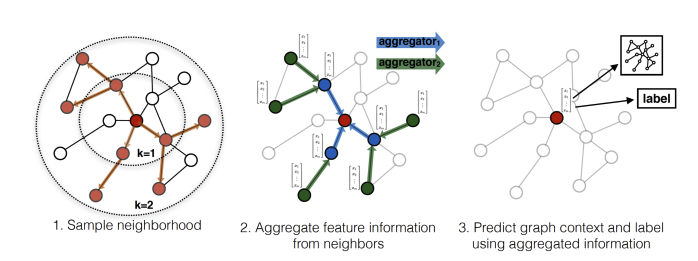

The working process of GraphSage is mainly divided into two steps, first performing <b>neighborhood sampling</b>  of an input graph and the second one is <b>learning aggregation functions</b> at each search depth. We will discuss each of these steps in detail starting with a little motivation of what was the need to perform the sampling of nodes neighborhood. Afterwards, we will discuss the importance of learning aggregator functions which basically had helped GraphSage algorithm to achieve its property of <b>inductiveness</b>.

Рабочий процесс GraphSage в основном разделен на два этапа: первый выполняет выборку окрестностей входного графа, а второй — изучение функций агрегирования на каждой глубине поиска. Мы обсудим каждый из этих шагов подробно, начиная с небольшого обоснования необходимости выполнения выборки окрестности узлов. После этого мы обсудим важность изучения функций агрегатора, которые, по сути, помогли алгоритму GraphSage достичь свойства индуктивности.


# Mini-batching

## What is the importance of Neighborhood Sampling?

Lets understand this from the perspective of Graph Convolutional Network diagram (GCNs) described below. GCNs is an algorithm which can leverage both the graph topological information (i.e. node's neighborhood) and node features and then distill this  information in order to generate node representations or dense vector embeddings. The below diagram represents the working process of GCNs intuitively. On the left hand side we have a sample input graph where its nodes are represented by their corresponding feature vectors (for e.g. node degree or text embeddings, etc). We start with defining a search depth (K) which informs the algorithm upto what depth it should gather the information from the neighborhood of a target node. Here, K is a hyperparameter and it also depicts the number of layers used in the GCNs.

At K=0, GCNs initializes all the node embeddings to their original feature vector. Now, let's say we want to compute the embeddings for the target node <i>0</i> at layer K=1, then we <b>aggregate</b> (it is permutation
invariant function to its neighbors) all the feature vectors of nodes (including itself) which are at 1-hop distance from the node <i>0</i> (at this timestep or layer we are aggregating the original feature representations of nodes which are at K=0). For the target node <i>0</i>, GCNs uses a mean aggregator to compute the mean of the neighborhood node features along with its own features (self-loop). After K=1, the target node <i>0</i> now knows about the information about its immediate neighborhood; this process is shown below in the GCNs image (r.h.s). We repeat this process for all the nodes in the graph (i.e. for every node, we aggregate over the 1-hop neighborhood) in order to find the new representations for each node at each layer.

<b>Note:</b> As the search depth increases, the reach of the target node in terms of aggregating features from its local neighborhood also increases. For e.g. at K=1 the target node knows the information about its local neighborhood which are 1-hop distance, at K=2 the target node knows the information about its local neighborhood which are at 1-hop distance and the neighbors of the nodes of 1-hop distance i.e upto 2-hop distance.

В чем важность выборки районов?
Давайте поймем это с точки зрения диаграммы сверточной сети графов (GCN), описанной ниже. GCN — это алгоритм, который может использовать как топологическую информацию графа (т. е. окрестность узла), так и характеристики узла, а затем очищать эту информацию для создания представлений узлов или плотных векторных вложений. На диаграмме ниже интуитивно представлен рабочий процесс GCN. С левой стороны у нас есть пример входного графа, узлы которого представлены соответствующими векторами признаков (например, степень узла или встраивание текста и т. д.). Мы начинаем с определения глубины поиска (K), которая сообщает алгоритму, до какой глубины он должен собирать информацию из окрестности целевого узла. Здесь K — гиперпараметр, который также указывает количество слоев, используемых в GCN.

При K=0 GCN инициализирует все вложения узлов в их исходный вектор признаков. Теперь предположим, что мы хотим вычислить вложения для целевого узла 0 на уровне K = 1, затем мы агрегируем (это функция, инвариантная к перестановке по отношению к своим соседям) все векторы признаков узлов (включая себя), которые находятся на 1-м шаге. расстояние от узла 0 (на этом временном шаге или слое мы агрегируем исходные представления объектов узлов, которые находятся в K = 0). Для целевого узла 0 GCN использует агрегатор средних значений для вычисления среднего значения функций соседнего узла вместе с собственными функциями (самоцикл). После K=1 целевой узел 0 теперь знает информацию о своем ближайшем соседстве; этот процесс показан ниже на изображении GCN (справа). Мы повторяем этот процесс для всех узлов графа (т. е. для каждого узла мы агрегируем по окрестностям с 1 шагом), чтобы найти новые представления для каждого узла на каждом уровне.

Примечание. По мере увеличения глубины поиска также увеличивается охват целевого узла с точки зрения агрегирования функций из его локального окружения. Например, при K=1 целевой узел знает информацию о своем локальном окружении, которое находится на расстоянии 1 шага, при K=2 целевой узел знает информацию о своем локальном окружении, которое находится на расстоянии 1 шага, и соседях узлов 1. Расстояние прыжка, т. е. расстояние до 2 прыжков.

## Issues with GCN approach
As we have discussed above, that GCNs compute node representations using neighborhood aggregation. For the training purposes, we can represent the k-hop neighborhood of a target node as a computational graph and send these computational graphs in a mini-batch fashion in order to learn the weights of the network (i.e. applying stochastic gradient descent). The below diagram illustrates a computational graph for the target node 0 upto 2-hop neighborhood. Now, the problem with this is that:

1) <b>Computationally Expensive</b>: Since for each node, we need to generate the complete K-hop neighborhood computational graph and then need to aggregate plenty of information from its surroundings. As we go deeper into the neighborhood (large K) computation graph becomes exponentially large. This could lead to a problem while fitting these big computational graphs inside GPU memory.

2) <b>The curse of Hub nodes or Celebrity nodes</b>: Hub nodes are those nodes which are very high degree nodes in the graph for eg. a very popular celebrity having millions of connections. If that is the case then we need to aggregate the information from millions of nodes in order to compute the embeddings for the hub node. Therefore, the generated computational graph for the hub node is very huge. This problem is illustrated below diagramatically (r.h.s).



Проблемы с подходом GCN
Как мы уже обсуждали выше, GCN вычисляют представления узлов, используя агрегацию окрестностей. В целях обучения мы можем представить окрестность k-прыжков целевого узла в виде вычислительного графа и отправить эти вычислительные графы в мини-пакетном режиме, чтобы узнать веса сети (т. е. применить стохастический градиентный спуск). На диаграмме ниже показан вычислительный граф для окрестности целевого узла от 0 до 2 переходов. Теперь проблема в том, что:

1) Вычислительные затраты: поскольку для каждого узла нам необходимо сгенерировать полный вычислительный граф окрестности K-перехода, а затем собрать большое количество информации из его окружения. По мере того, как мы углубляемся в окрестность (большое K), граф вычислений становится экспоненциально большим. Это может привести к проблемам при размещении этих больших вычислительных графиков в памяти графического процессора.

2) Проклятие узлов-концентраторов или узлов-знаменитостей: узлы-концентраторы — это те узлы, которые являются узлами очень высокой степени в графе, например. очень популярная знаменитость, имеющая миллионы связей. Если это так, то нам нужно агрегировать информацию из миллионов узлов, чтобы вычислить внедрения для узлового узла. Таким образом, сгенерированный вычислительный граф для узла-концентратора очень огромен. Эта проблема проиллюстрирована ниже схематически (справа).

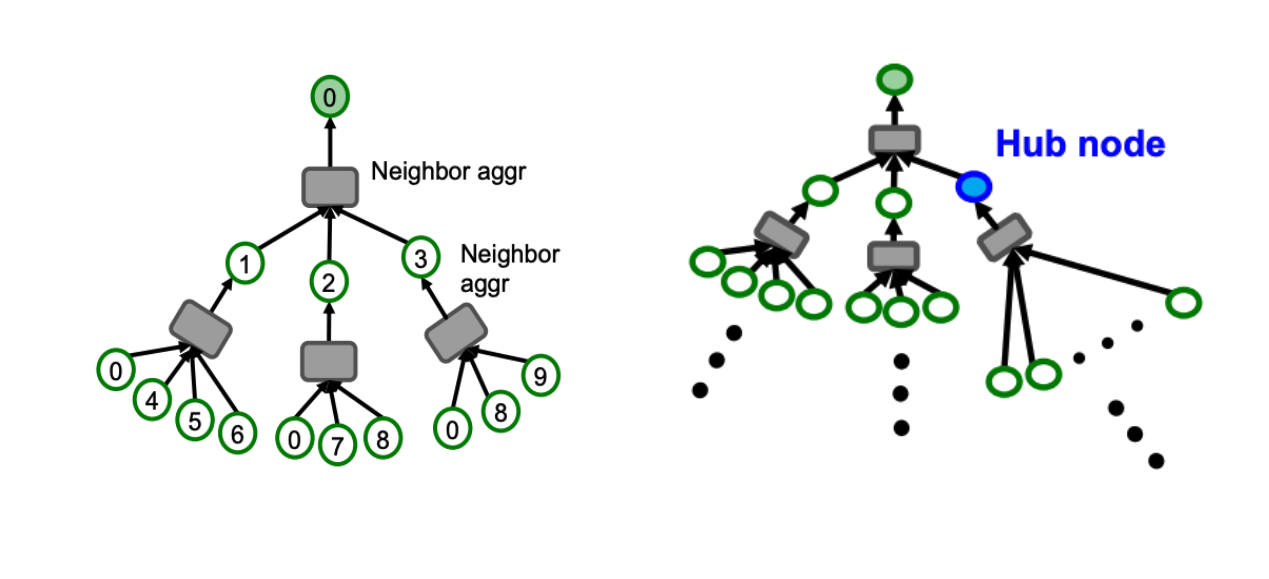

Therefore, the idea is not take the entire K-hop neighborhood of a target node but select few nodes at random from the K-hop neighborhood in order to generate computational graph. This process is known as neighborhood sampling which provides the GraphSage algorithm its unique ability of <b>scaling up to billion of nodes</b> in the graph. Therefore, using this approach if we encounter any hub node then we are not going to take its entire K-hop neighborhood but rather select few nodes at random from each layer or search depth K. Now, the generated computational graph is more efficient to handle by the GPU. Below diagram shows this process by sampling at most 2 neighbors at each hop.


Таким образом, идея заключается не в том, чтобы брать всю окрестность K-прыжков целевого узла, а в случайном выборе нескольких узлов из окрестности K-прыжков для создания вычислительного графа. Этот процесс известен как выборка окрестностей, которая обеспечивает алгоритму GraphSage уникальную возможность масштабирования до миллиарда узлов в графе. Следовательно, используя этот подход, если мы сталкиваемся с каким-либо узлом-концентратором, мы не собираемся брать всю его окрестность K-hop, а скорее выберем несколько узлов случайным образом из каждого слоя или глубины поиска K. Теперь сгенерированный вычислительный граф более эффективен для обработки. со стороны ГПУ. На диаграмме ниже показан этот процесс путем выборки не более двух соседей на каждом прыжке.

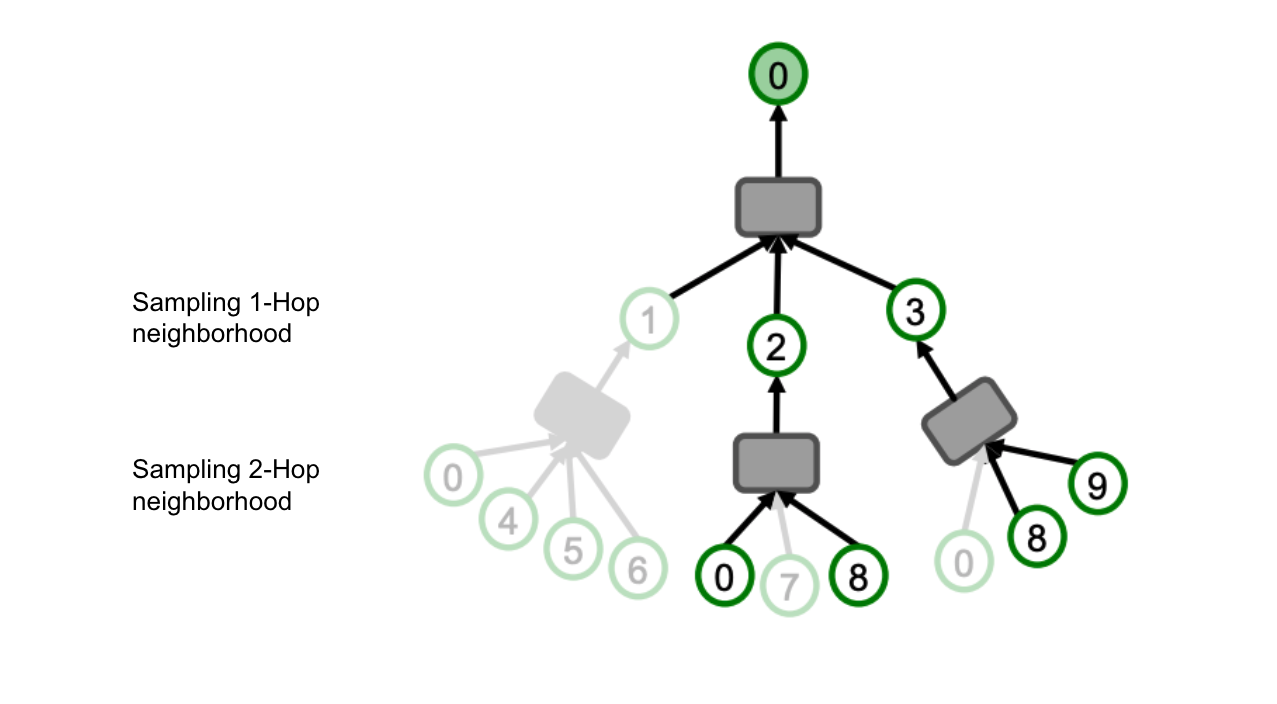

### TASK 2

Addapt the following code for your data


**3 points**

In [ ]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx



In [ ]:
data = dataset.data
train_mask = torch.zeros(len(dataset))
train_mask[:3000] = 1
train_mask = train_mask > 0

val_mask = torch.zeros(len(dataset))
val_mask[3000:3500] = 1
val_mask = val_mask > 0


test_mask = torch.zeros(len(dataset))
test_mask[3500:] = 1
test_mask = test_mask > 0

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:290: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [ ]:
val_mask[3000:3600]

In [ ]:
# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=train_mask##Index of train nodes,
)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [ ]:
for i, subgraph in enumerate(train_loader):
  if i < 4:
    print(f'Subgraph {i}: {subgraph}')

Subgraph 0: Data(x=[23, 784], edge_index=[2, 100], y=[4337], edge_weight=[100], train_mask=[4337], val_mask=[4337], test_mask=[4337], n_id=[23], e_id=[100], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[34, 784], edge_index=[2, 160], y=[4337], edge_weight=[160], train_mask=[4337], val_mask=[4337], test_mask=[4337], n_id=[34], e_id=[160], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[33, 784], edge_index=[2, 150], y=[4337], edge_weight=[150], train_mask=[4337], val_mask=[4337], test_mask=[4337], n_id=[33], e_id=[150], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[40, 784], edge_index=[2, 190], y=[4337], edge_weight=[190], train_mask=[4337], val_mask=[4337], test_mask=[4337], n_id=[40], e_id=[190], input_id=[16], batch_size=16)


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


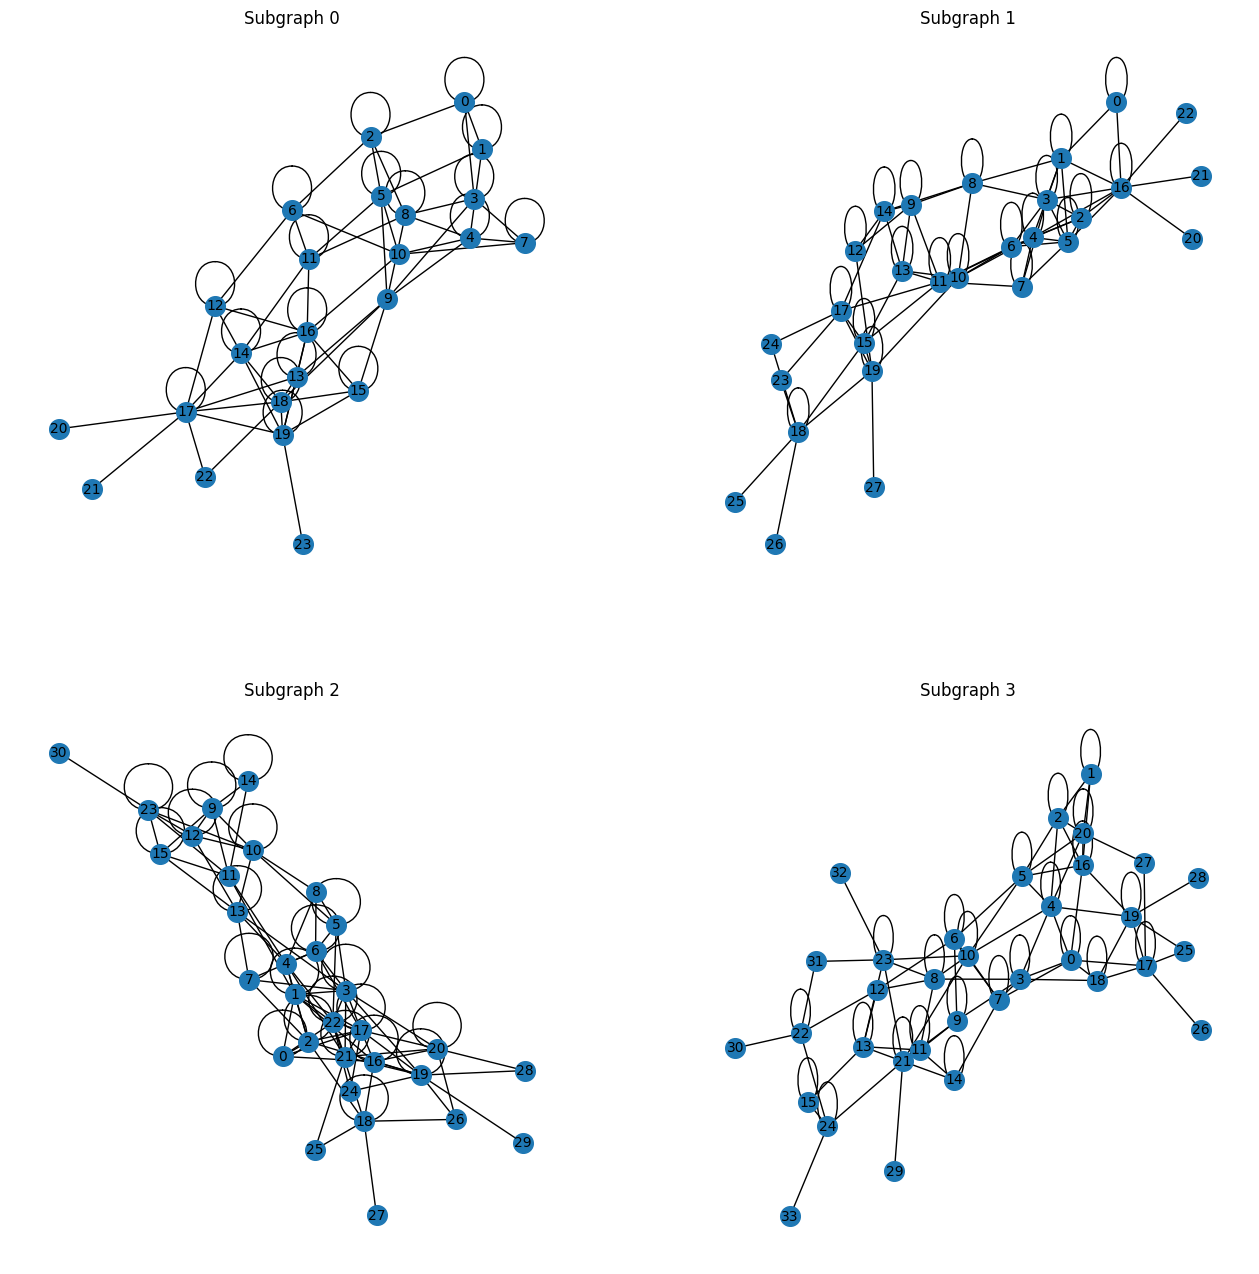

In [ ]:
import matplotlib.pyplot as plt


# Plot each subgraph
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(train_loader, ['221', '222', '223', '224'])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(int(pos))
    ax.set_title(f'Subgraph {idx}')
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=200,
                    # node_color=subdata.y,
                    cmap="cool",
                    font_size=10
                    )
plt.show()

# Plot node degrees

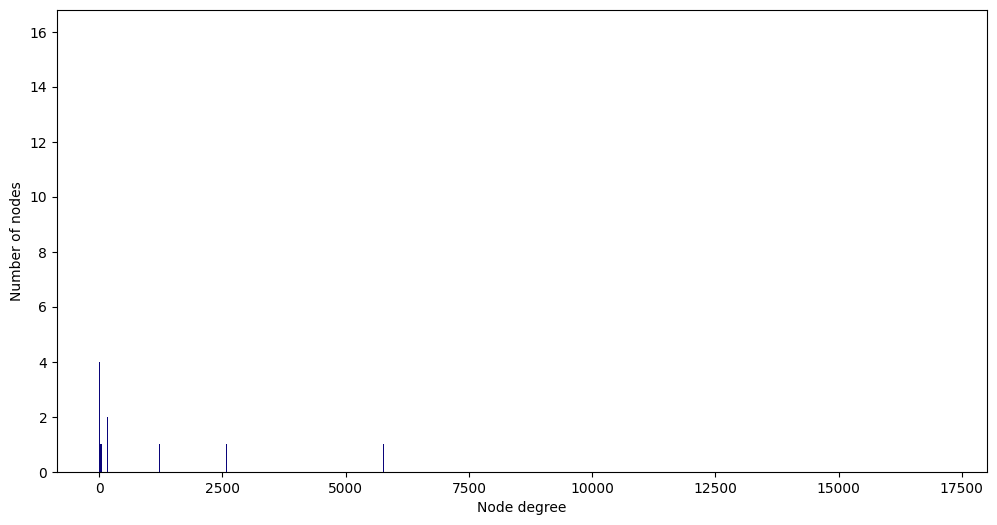

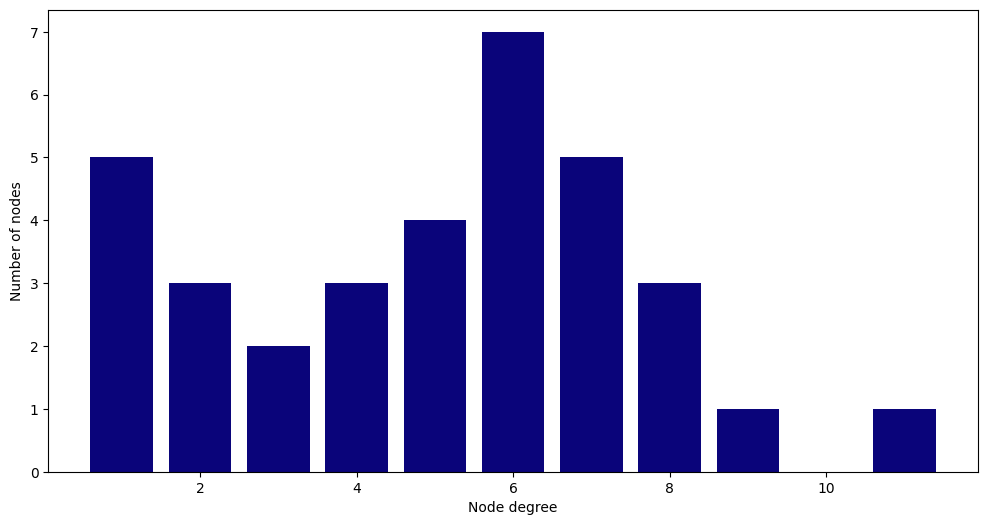

In [ ]:
from torch_geometric.utils import degree
from collections import Counter

def plot_degree(data):
  # Get list of degrees for each node
  degrees = degree(data.edge_index[0]).numpy()

  # Count the number of nodes for each degree
  numbers = Counter(degrees)

  # Bar plot
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.set_xlabel('Node degree')
  ax.set_ylabel('Number of nodes')
  plt.bar(numbers.keys(),
          numbers.values(),
          color='#0A047A')

# Plot node degrees from the original graph
plot_degree(data)

# Plot node degrees from the last subgraph
plot_degree(subdata)

# Implement GraphSage vs.  GCN

The key concept of GraphSage is to learn how to aggregate feature information from a node’s local neighborhood. Now, let's understand more formally how the GraphSage generates node embedding at each layer (K) using forward propagation. We understand this with the help of visuals and then map this understanding to a pseudocode mentioned in the [GraphSage paper](https://arxiv.org/pdf/1706.02216.pdf). But before that, lets define some notations which are used in the paper.

Ключевая концепция GraphSage — научиться агрегировать информацию о функциях из локального окружения узла. Теперь давайте более формально разберемся, как GraphSage генерирует встраивание узлов на каждом уровне (K) с использованием прямого распространения. Мы понимаем это с помощью визуальных эффектов, а затем сопоставляем это понимание с псевдокодом, упомянутым в статье GraphSage. Но перед этим давайте определимся с некоторыми обозначениями, которые используются в статье.

## Defining Notations:

x<sub>v</sub> = Feature vector of a node <b>v</b>

h<sub>v</sub><sup>0</sup> = Initial node embeddings representation for a node <b>v</b> (original feature vectore e.g. text or image embeddings)

h<sub>v</sub><sup>k</sup>  = Node embedding representation for a node <b>v</b> at the K-th layer or search depth

z<sub>v</sub> = Final representation of a node <b>v</b> after K layers

V = Set of nodes in the graph

W<sup>K</sup> = Weight matrix at the K-th layer

<i>N</i> : v → 2<sup>v</sup> = Neighborhood function

Определение обозначений:
xv = вектор признаков узла v

hv0 = Начальное представление внедрений узла для узла v (исходный вектор признаков, например, внедрение текста или изображения)

hvk = Представление внедрения узла для узла v на K-м слое или глубине поиска

zv = Окончательное представление узла v после K слоев

V = набор узлов на графике

WK = Весовая матрица на K-м слое

N : v → 2v = функция соседства

As seen in the above GraphSage diagram that at K=1, the target node <b>0</b> aggregates information (features) from its local neighbors upto 1-hop. Similarly at k=2, the target node <b>0</b> aggregates information from its local neighbors upto 2-hops i.e now it knows what lies in its neighborhood upto 2-hops. Therefore, we can iterate this process where target node <b>0</b> incrementally obtain more and more
information from further reaches of the graph. We do this process of information gathering for each of the nodes in the original graph (∀v ∈ V).
Lets add some visuals to understand this iterative process much more intuitively:

Как видно на приведенной выше диаграмме GraphSage, при K=1 целевой узел <b>0</b> объединяет информацию (функции) от своих локальных соседей до 1-го шага. Аналогично при k=2 целевой узел <b>0</b> объединяет информацию от своих локальных соседей до 2-х шагов, т. е. теперь он знает, что находится в его окрестности до 2-х шагов. Следовательно, мы можем повторять этот процесс, где целевой узел <b>0</b> постепенно получает все больше и больше
информацию из дальних уголков графа. Мы выполняем этот процесс сбора информации для каждого узла исходного графа (∀v ∈ V).
Давайте добавим несколько визуальных эффектов, чтобы более интуитивно понять этот итеративный процесс:

The following image depicts the computation graph of target node <b>0</b> at layer K=0, at this point of time all the nodes in the graph are initialized to their original feature vectors. Our aim is to find the final representation of node <b>0</b> (i.e z<sub>0</sub>) at layer K=2 through an iterative local neighborhood information gathering process. This iterative process is also sometime known as <b>message passing approach </b>.

Therefore, we can represent this step formally as :

# <b>h<sub>v</sub><sup>0</sup> ← x<sub>v</sub>, ∀v ∈ V </b>

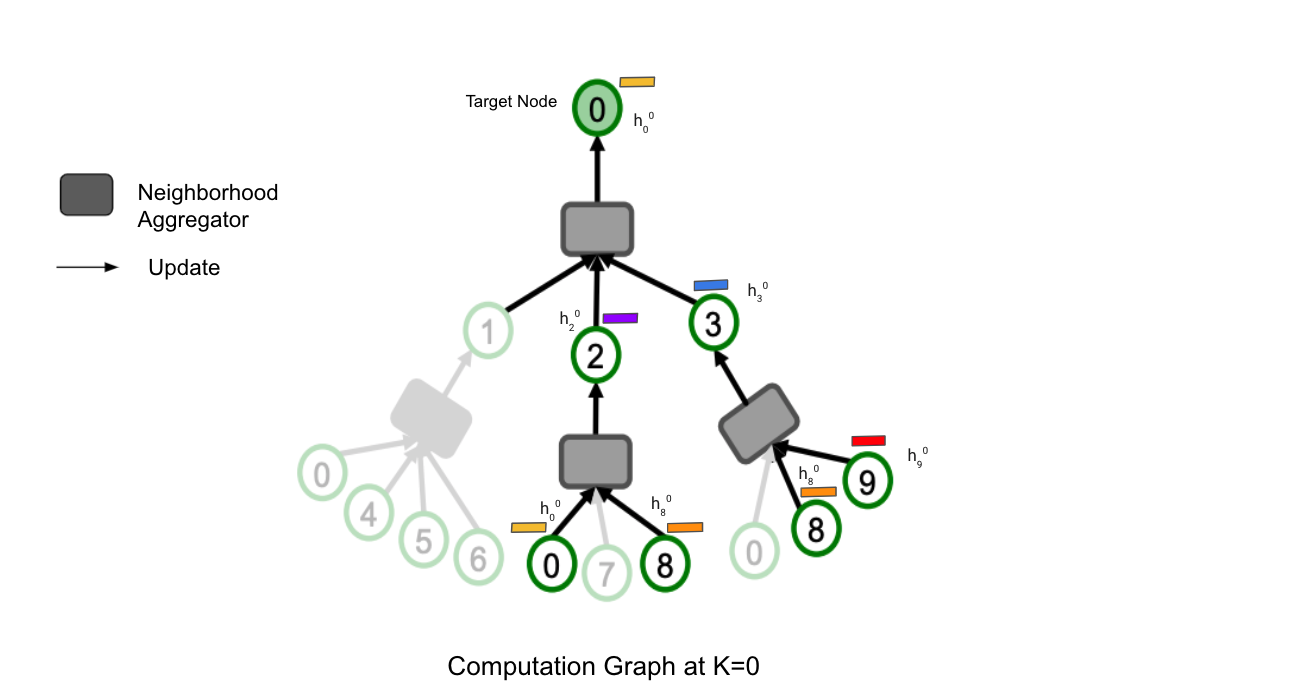

## TASK 3

Use batch masking or replace batch.train_mask, batch.val_mask, batch.test_mask to your corrsponding data

**3 points**

In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import SAGEConv, GCNConv


class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h)
    self.sage2 = SAGEConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        _, out = self(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1),
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1),
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')


class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

# Train GraphSAGE

In [ ]:
%%time
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(data, 200)

# Test
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(784, 64, aggr=mean)
  (sage2): SAGEConv(64, 2, aggr=mean)
)


IndexError: ignored

# Train GCN

In [ ]:
%%time

# Create GCN
gcn = GCN(dataset.num_features, 64, dataset.num_classes)
print(gcn)

# Train
gcn.fit(data, 200)

# Test
print(f'\nGCN test accuracy: {test(gcn, data)*100:.2f}%\n')

##TASK 4

Make a comparison of two networks

**4 points**

YOUR TEXT COMPARISON HERE